# Expected Output

In [3]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import os
from random import sample
import pickle
from common_functions import *

import matplotlib as mpl
mpl.rc('image', cmap='gray')

# Functions to Process Rasters

In [4]:
def get_test_set_predictions(interior_training_vals, exterior_training_vals, split_arr_features_test, arr_test_labels, arr_test_labels_mask):
    """
    This function uses the cached training data to make predictions about wetlands in a testing region
    
    interior_training_vals: N x k matrix of training data at pixels confidently marked as the given wetland sub-type
    exterior_training_vals: M x k matrix of training data at pixels confidently marked as NOT the given wetland sub-type
    split_arr_features_test: the features for the test region
    arr_test_labels: the labels for the test region
    arr_test_labels_mask: a data mask for the labels at the rest region
    """
    
    #get number of bands, scale, and compute how many sub-cells to sample
    num_bands = split_arr_features_test.shape[-1]
    scale = split_arr_features_test.shape[-2]
    MAX_VAL = 2
    
    #sample from wetlands and non wetlands
    wetland_idxs_x, wetland_idxs_y = np.where((arr_test_labels == 1)&(arr_test_labels_mask == 1))
    
    non_wetland_idxs_x, non_wetland_idxs_y = np.where((arr_test_labels == 0)&(arr_test_labels_mask == 1))
    
    #get testing indices for x and y and sample those sub-cells
    testing_idx_wetlands = np.arange(wetland_idxs_x.shape[0])
    wetland_idxs = (wetland_idxs_x[testing_idx_wetlands], wetland_idxs_y[testing_idx_wetlands])
    print('len wetland idxs: %s'%len(wetland_idxs[0]))
    
    testing_idx_non_wetlands = np.arange(non_wetland_idxs_x.shape[0])
    non_wetland_idxs = (non_wetland_idxs_x[testing_idx_non_wetlands], non_wetland_idxs_y[testing_idx_non_wetlands])
    print('len non-wetland idxs: %s'%len(non_wetland_idxs[0]))
    
    testing_idx_tuple = (np.concatenate([wetland_idxs[0], non_wetland_idxs[0]]), np.concatenate([wetland_idxs[1], non_wetland_idxs[1]]))
    
    split_arr_features_test_sampled = split_arr_features_test[testing_idx_tuple]
    arr_test_labels_sampled = arr_test_labels[testing_idx_tuple]
    
    #reshape the testing data into num_bands columns
    testing_vals = split_arr_features_test_sampled.reshape(-1, num_bands)
        
    approx_densities_interior, histogram_wetlands = get_approx_densities(interior_training_vals, testing_vals, 2.5, 10)
    print('got interior histogram')
    approx_densities_exterior, histogram_non_wetlands = get_approx_densities(exterior_training_vals, testing_vals, 2.5, 10)
    print('got exterior histogram')

    scores = approx_densities_interior / approx_densities_exterior
    scores[scores < 0] = 0
    scores = 2/(1 + np.exp(-scores)) - 1

    aux_data = {'histogram_wetlands': histogram_wetlands, 'histogram_non_wetlands': histogram_non_wetlands, 'testing_vals': testing_vals}
        
    scores = scores.reshape((-1,scale,scale))
        
    return scores, arr_test_labels_sampled, testing_idx_tuple, aux_data

In [5]:
def predictions_to_map(orig_arr, scale, fill_indices, fills, post_upsample_blur=None):
    """
    This function takes the predictions about a test region and generates a numpy matrix of the map so it can be
    converted to a raster file.
    
    orig_arr: the original, low resultion image
    scale: the degree of upsampling
    fill_indices: the coordinates of orig_arr to give more continuous wetland confidence
    fills: the continuous weland confidence scores
    post_upsample_blur: how much to blur the resulting upsampled image to induce continuity
    """
    
    NON_SAMPLED_VALUE = -1
    
    #create an empty array like the original array
    small_arr = np.ones_like(orig_arr).astype(float)*NON_SAMPLED_VALUE
    
    #create the eventual upsampled array
    upsamp_arr = np.repeat(np.repeat(small_arr, scale, axis=1), scale, axis=0)
    
    #transform indices for the edges
    scaled_edge_x = np.repeat(fill_indices[0]*scale, scale**2) + np.tile(np.repeat(np.arange(scale), scale), len(fill_indices[0]))
    scaled_edge_y = np.repeat(fill_indices[1]*scale, scale**2) + np.tile(np.tile(np.arange(scale), scale), len(fill_indices[1]))
    scaled_edges = (scaled_edge_x, scaled_edge_y)
    
    #vectorized setting of all continious edge wetland confidences to the appropriate portions of the upsampled array
    upsamp_arr[scaled_edges] = fills.flatten()
    
    #blur the upsampled array if needed
    if post_upsample_blur != None:
        post_upsample_blur_kernel = np.ones((post_upsample_blur,post_upsample_blur)) / (post_upsample_blur**2)
        convolved_arr = apply_convolution(upsamp_arr, post_upsample_blur_kernel)
        
        thresh = 0.2
        upsamp_arr[convolved_arr < thresh] = 0
    
    return upsamp_arr, scaled_edges

# Driver Code

In [6]:
base = 'C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/'

In [8]:
training_data = pickle.load(open('stored_training_data.p', 'rb'))

In [13]:
regions_of_interest = list(training_data.keys())

In [15]:
wetland_type = 'Marsh'

In [16]:
#the number of training regions to use when predicting each testing region
num_training_regions = min(5, len(training_data)-1)

C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_4/features_inland_wetland_1_4.tiff C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_4/baseline_inland_wetland_1_4.tiff
Getting formatted features and labels...
Assembling training data...
Building Histograms...
len wetland idxs: 44111
len non-wetland idxs: 129578
got interior histogram
got exterior histogram
Generating Predicted Map...


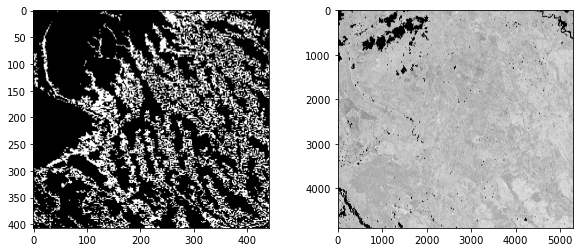

Saving Predicted Map to Raster...
C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_2/features_inland_wetland_1_2.tiff C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_2/baseline_inland_wetland_1_2.tiff
Getting formatted features and labels...
Assembling training data...
Building Histograms...
len wetland idxs: 8091
len non-wetland idxs: 156906
got interior histogram
got exterior histogram
Generating Predicted Map...


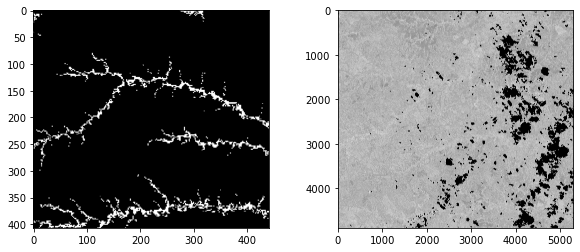

Saving Predicted Map to Raster...
C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_1/features_inland_wetland_1_1.tiff C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_1/baseline_inland_wetland_1_1.tiff
Getting formatted features and labels...
Assembling training data...
Building Histograms...
len wetland idxs: 7176
len non-wetland idxs: 158820
got interior histogram
got exterior histogram
Generating Predicted Map...


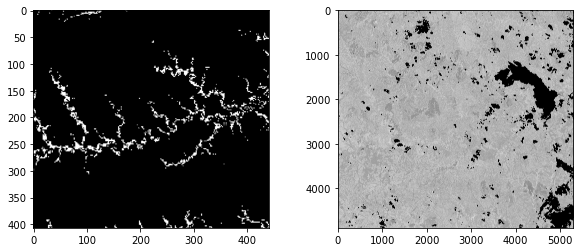

Saving Predicted Map to Raster...
C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_3/features_inland_wetland_1_3.tiff C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_3/baseline_inland_wetland_1_3.tiff
Getting formatted features and labels...
Assembling training data...
Building Histograms...
len wetland idxs: 22763
len non-wetland idxs: 147630
got interior histogram
got exterior histogram
Generating Predicted Map...


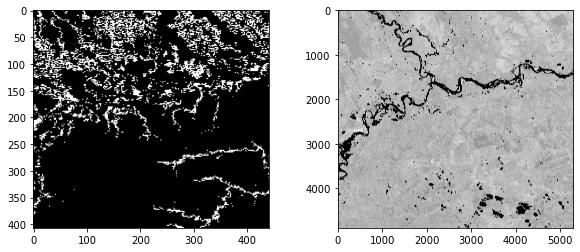

Saving Predicted Map to Raster...
C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_0/features_inland_wetland_1_0.tiff C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/inland_wetland_1_0/baseline_inland_wetland_1_0.tiff
Getting formatted features and labels...
Assembling training data...
Building Histograms...
len wetland idxs: 9080
len non-wetland idxs: 144333
got interior histogram
got exterior histogram


C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


Generating Predicted Map...


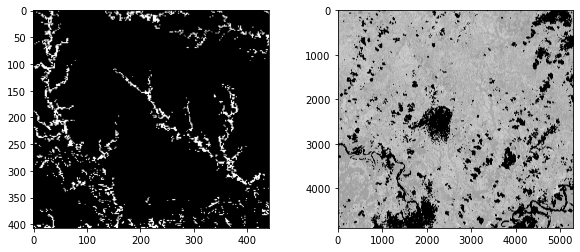

Saving Predicted Map to Raster...


In [17]:
for folder in regions_of_interest:
        
    test_labels_file = '%s%s/baseline_%s.tiff'%(base, folder, folder)
    test_features_file = '%s%s/features_%s.tiff'%(base, folder, folder)
    
    print(test_features_file, test_labels_file)
    
    ds_features = gdal.Open(test_features_file, gdal.GA_ReadOnly)
    ds_labels = gdal.Open(test_labels_file, gdal.GA_ReadOnly)
    gt_labels = ds_labels.GetGeoTransform()

    #get other regions that will be used for training
    other_regions = sample([item for item in training_data.keys() if item != folder], num_training_regions)

    print('Getting formatted features and labels...')
    arr_test_labels, split_arr_features_test, gt_features_test = preprocess_data_set_pair(ds_features, ds_labels, wetland_type)

    print('Assembling training data...')
    interior_training_vals = np.concatenate([training_data[oth]['interior'] for oth in other_regions], axis=0)
    exterior_training_vals = np.concatenate([training_data[oth]['exterior'] for oth in other_regions], axis=0)

    #build mask for test region labels
    arr_test_labels_mask = np.ones_like(arr_test_labels)
    arr_test_labels_mask[(split_arr_features_test == NO_DATA_VALUE).any(axis = (2,3,4))] = 0
    arr_test_labels_mask[arr_test_labels ==-1] = 0

    print('Building Histograms...')
    scores, arr_test_labels_sampled, testing_idx_tuple, aux_data = get_test_set_predictions(interior_training_vals, exterior_training_vals, split_arr_features_test, arr_test_labels, arr_test_labels_mask)
    
    scale = split_arr_features_test.shape[-2]

    print('Generating Predicted Map...')
    filled_arr, scaled_edges = predictions_to_map(arr_test_labels, scale, testing_idx_tuple, scores)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow((arr_test_labels == 1))

    plt.subplot(1,2,2)
    plt.imshow(filled_arr)

    plt.show()

    fname_corrected = '%s%s/corrected_%s.tiff'%(base, folder, folder)
    fname_specific_baseline = '%s%s/baseline_%s_%s.tiff'%(base, folder, wetland_type, folder)

    print("Saving Predicted Map to Raster...")
    ds = np_array_to_raster(fname_corrected, filled_arr, gt_features_test, no_data=-1, nband=1, gdal_data_type=gdal.GDT_Float64)
    ds = None
    
    ds = np_array_to_raster(fname_specific_baseline, arr_test_labels, gt_labels, no_data=-1, nband=1, gdal_data_type=gdal.GDT_Float64)
    ds = None
    
    ds_features = None
    ds_labels = None

    print('===============================================')